In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt




In [41]:
seq_len = 10
batch_size = 16
input_dim = 64
output_dim = 64  # lets consider regression task
num_samples = 1000

In [42]:
input_data = torch.randn(num_samples, seq_len, input_dim) #1000,10,64 shape
labels = torch.randn(num_samples, output_dim) #1000,64

# Splitting the dataset into training and validation sets
train_input, val_input = torch.split(input_data, int(num_samples * 0.8))
train_labels, val_labels = torch.split(labels, int(num_samples * 0.8))

# DataLoader for batching
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_input, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [43]:
#  self-attention layer
class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.multihead_attention = nn.MultiheadAttention(input_dim, num_heads)
        self.layer_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        #x = self.self_attention(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, input_dim)
        attn_output, _ = self.multihead_attention(x, x, x)
        x = x + attn_output
        x = self.layer_norm(x)
        return x

In [44]:
class DeepSelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers):
        super(DeepSelfAttention, self).__init__()
        self.layers = nn.ModuleList([SelfAttention(input_dim, hidden_dim, num_heads) for _ in range(num_layers)])
        #self.self_attention = SelfAttention(input_dim, hidden_dim, num_heads)

        self.final_linear = nn.Linear(input_dim, output_dim)  # Linear layer to map to output_dim (64,64)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=1)  # Average pooling over the sequence
        x = self.final_linear(x)  # Linear transformation to the desired output shape
        return x

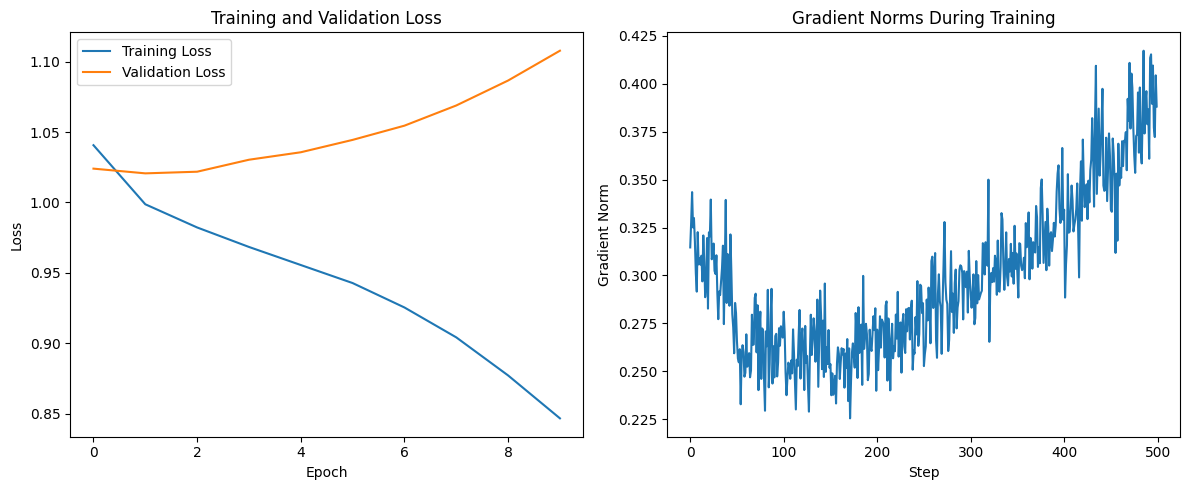

In [45]:
num_heads = 4
num_layers = 6
model = DeepSelfAttention(input_dim, input_dim * 2, num_heads, num_layers)
#model = SingleSelfAttention(input_dim, input_dim * 2, num_heads)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Tracking metrics
training_losses = []
validation_losses = []
gradient_norms = []

for epoch in range(10):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Calculate and store gradient norms to evaluate vanishing/exploding gradient
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms.append(total_norm)

        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    training_losses.append(train_loss / len(train_loader))
    validation_losses.append(val_loss / len(val_loader))

# Visualizations
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting gradient norms
plt.subplot(1, 2, 2)
plt.plot(gradient_norms)
plt.xlabel('Step')  #approx 63 steps in one epoch
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms During Training')

plt.tight_layout()
plt.show()
